# Sep 12, 2025: model comparison

conda env: gt

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import dill as pickle 
from scipy import sparse, stats
from scipy.special import gammaln
import graph_tool.all as gt
from glob import glob
import re 
from tqdm import tqdm
from itertools import combinations
import math
from joblib import Parallel, delayed
# plotting
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cycler import cycler
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

from scipy.stats import wilcoxon, ttest_rel
from statsmodels.stats.multitest import multipletests

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

def setup_plotting(palette=None, context="paper", fontsize=7):
    """
    Configure seaborn with 'paper' context and synced matplotlib rcParams.
    """
    setup_mpl(fontsize)

    if palette is None:
        try:
            from cycler import cycler
            cycle = mpl.rcParams['axes.prop_cycle']
            palette = [d['color'] for d in cycle]
        except Exception:
            palette = sns.color_palette("colorblind")

    sns.set_theme(
        context=context,       # use "paper"
        style="white", 
        palette=palette, 
        rc=mpl.rcParams
    )

    setup_mpl(fontsize)

In [3]:
# setup_plotting(context='paper', fontsize=7)
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

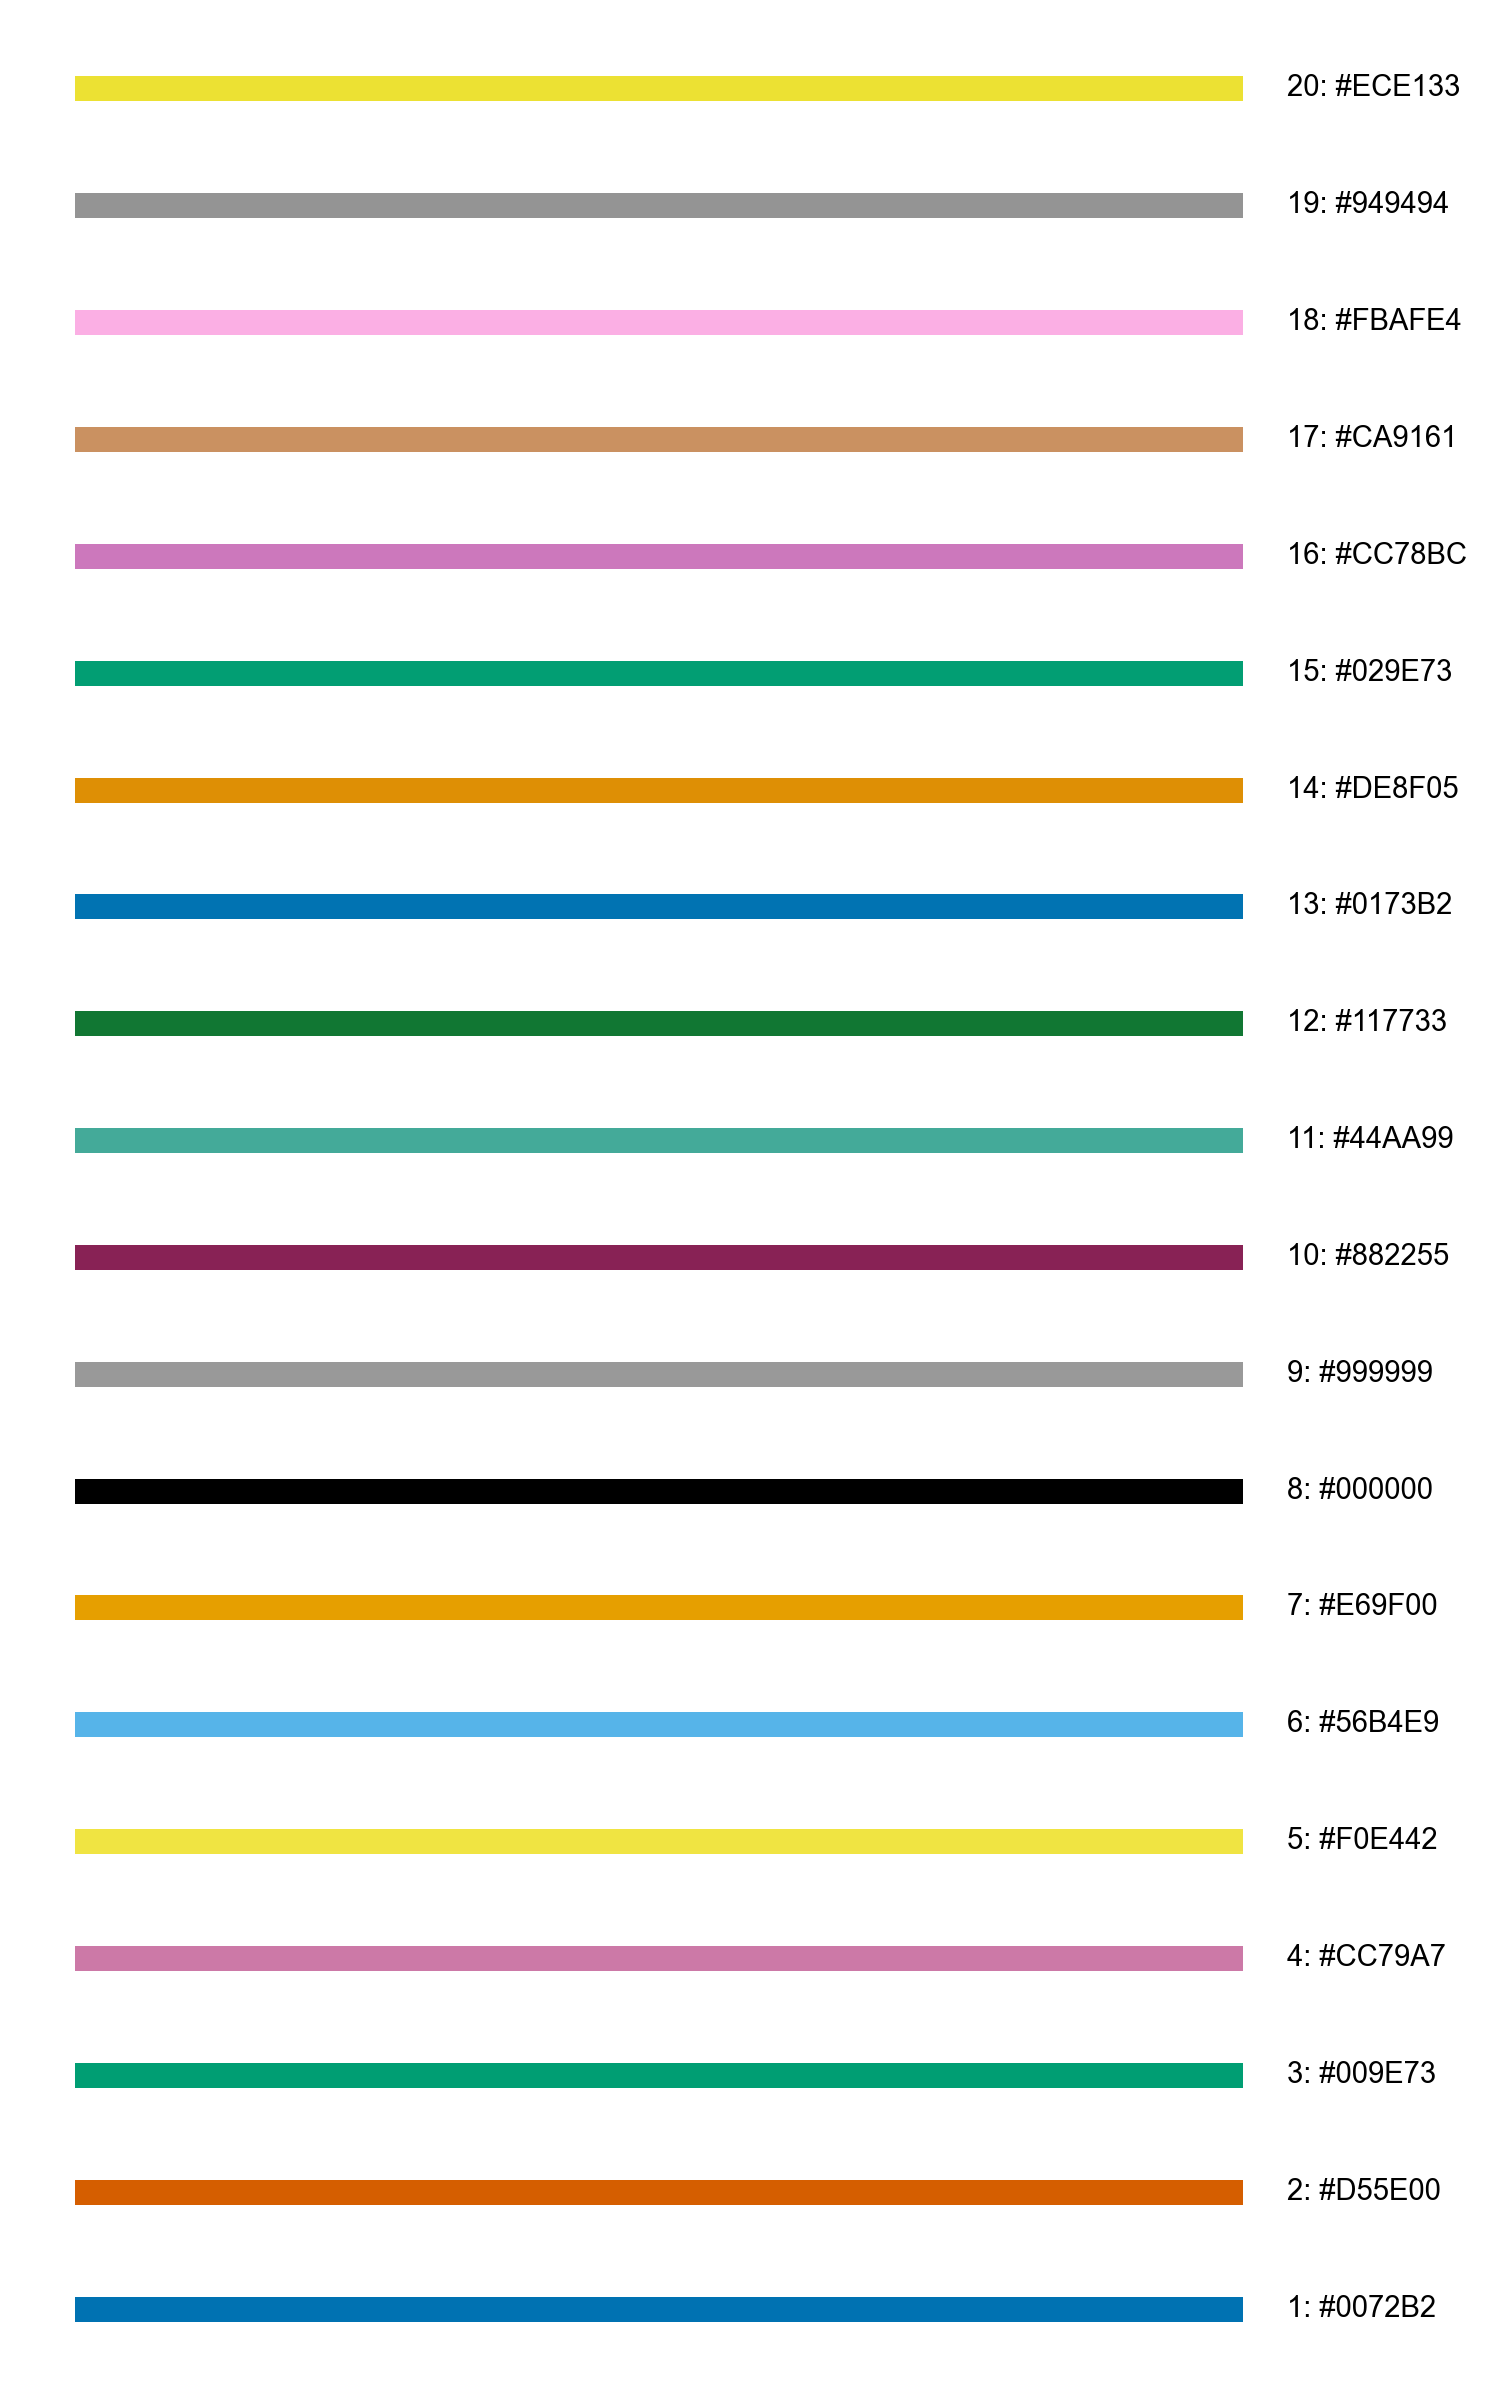

In [4]:
def preview_colorblind_palette():
    colors = get_colorblind_palette()
    n = len(colors)
    
    fig, ax = plt.subplots(figsize=(5, 0.4 * n))
    for i, color in enumerate(colors):
        ax.plot([0, 1], [i, i], color=color, linewidth=6)
        ax.text(1.05, i, f"{i+1}: {color}", va='center', ha='left', fontsize=7)
    
    ax.set_ylim(-0.5, n - 0.5)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
preview_colorblind_palette()

| Color     | HEX       | Use |
|-----------|-----------|-----|
| Blue      | `#0072B2` | Chain 1 |
| Vermilion | `#D55E00` | Chain 2 |
| Green     | `#009E73` | Chain 3 |
| Purple    | `#CC79A7` | Chain 4 |
| Yellow    | `#F0E442` | Chain 5 |
| Light Blue| `#56B4E9` | Chain 6 |
| Orange    | `#E69F00` | Chain 7 |
| Black     | `#000000` | Chain 8 |

In [5]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [6]:
args.ANALYSIS = 'trial-end'
# args.WINDOW = np.arange(5, 8+1)
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'grp'

BASE_path = f'/home/govindas/lab-data/aba'
PARC_DESC = f'ABA_ROIs_final_gm_36' #f'NEWMAX_ROIs_final_gm_104_2mm' #f'ABA_ROIs_final_gm_36'
ROI_path = (
    f'{BASE_path}/{PARC_DESC}'
)
os.makedirs(ROI_path, exist_ok=True)
TS_path = f'{ROI_path}/roi-timeseries'
os.makedirs(TS_path, exist_ok=True)

ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/analysis-{args.ANALYSIS}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
SBM_path = f'{ROI_RESULTS_path}/model-fits'
DIAG_path = f'{ROI_RESULTS_path}/diagnostics_insets'
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.makedirs(f'{ESTIM_path}/group', exist_ok=True)

In [7]:
def collect_evidences(args, evidence_files):
    ldf = []
    for file in evidence_files[:]:
        match = re.search(r'(sbm-[^/]+)/B-(\d+)/cond-([^/]+)_([^/]+)', file)
        if match:
            sbm, B, cond, name = match.groups()
            cond = '_'.join([cond, name])
        
        with open(f'{file}', 'rb') as f:
            [L] = pickle.load(f)
        
        row = pd.DataFrame(dict(
            sbm=[sbm],
            B=[B],
            cond=[cond],
            L=[-L], # flipped sign to convert evidence to total description length
        ))
        ldf += [row]
    ldf = pd.concat(ldf).reset_index(drop=True)
    pdf = ldf.pivot(index=['cond', 'B'], columns='sbm', values='L')
    return ldf, pdf

In [8]:
def sort_sbms(pdf):
    rank_df = pdf.rank(axis=1, method='min', ascending=True)
    modal_ranks = stats.mode(rank_df.to_numpy(), axis=0).mode
    cols_sorted = [col for _, col in sorted(zip(modal_ranks, pdf.columns))]
    return pdf[cols_sorted]

In [9]:
evidence_files = sorted(glob(f'{SBM_path}/sbm-*/B-*/cond-*/desc-evidence.pkl'))
ldf, pdf = collect_evidences(args, evidence_files)
pdf = sort_sbms(pdf)

In [10]:
pdf = pdf.rename(columns={'sbm-nd-d': 'sbm-nd-s', 'sbm-dc-d': 'sbm-dc-s'})
pdf

sbm              sbm-nd-h    sbm-dc-h      sbm--a
cond       B                                     
PLAY_highR 1   235.088107  245.241298  247.429164
           10  234.805139  245.273685  247.429164
           19  234.651291  245.092803  247.429164
           28  233.806826  245.197730  247.429164
           37  235.148104  245.230815  247.429164
PLAY_highT 1   222.422748  234.259487  236.198472
           10  222.900391  234.210199  236.198472
           19  222.819285  234.112420  236.198472
           28  222.149687  234.270037  236.198472
           37  222.983361  234.325931  236.198472
PLAY_lowR  1   230.233221  235.232454  235.911163
           10  225.658176  235.194048  235.911163
           19  229.973946  234.896336  235.911163
           28  230.239572  235.212507  235.911163
           37  230.450275  235.009519  235.911163
PLAY_lowT  1   246.786720  253.825137  254.566355
           10  246.804128  253.758684  254.566355
           19  246.943396  253.636650  254.566355
           28  245.295720  253.774054  254.566355
           37  247.016710  253.212836  254.566355

In [11]:
pdf.loc['PLAY_highT']

sbm,sbm-nd-h,sbm-dc-h,sbm--a
B,,,
1,222.422748,234.259487,236.198472
10,222.900391,234.210199,236.198472
19,222.819285,234.112420,236.198472
28,222.149687,234.270037,236.198472
37,222.983361,234.325931,236.198472


In [12]:
def compare_description_lengths(df, test='wilcoxon'):
    results = {}
    for col1, col2 in combinations(df.columns, 2):
        mask = df[[col1, col2]].notna().all(axis=1)
        if mask.sum() > 1:
            x1, x2 = df[col1][mask], df[col2][mask]
            if test == 'wilcoxon':
                stat, pval = wilcoxon(x1, x2, alternative='two-sided')
            elif test == 'ttest':
                result = ttest_rel(x1, x2, alternative='two-sided')
                stat, pval = result.statistic, result.pvalue
            median_diff = (x1 - x2).median()
            better_model = col1 if median_diff < 0 else col2 # smaller DL is better
            results[(col1, col2)] = {
                'Wilcoxon Stat': stat,
                'p-value': pval,
                'Median Diff': median_diff,
                'Better Model': better_model,
            }
    comps_df = pd.DataFrame(results).T
    comps_df['p-value FDR'] = multipletests(comps_df['p-value'], method='bonferroni')[1]
    return comps_df

In [13]:
cond = 'PLAY_highT'
comps_df = compare_description_lengths(pdf.loc[cond])

In [14]:
comps_df

Wilcoxon Stat p-value Median Diff Better Model p-value FDR
sbm-nd-h sbm-dc-h           0.0  0.0625   -11.34257     sbm-nd-h      0.1875
         sbm--a             0.0  0.0625  -13.379186     sbm-nd-h      0.1875
sbm-dc-h sbm--a             0.0  0.0625   -1.938984     sbm-dc-h      0.1875

In [15]:
# def get_long_df(pdf):
#     long_df = pdf.reset_index(drop=True).melt(var_name='SBM', value_name='DL')
#     long_df['chain'] = np.tile(np.arange(pdf.shape[0]), len(pdf.columns))
#     long_df['SBM'] = pd.Categorical(long_df['SBM'], categories=pdf.columns.tolist(), ordered=True)
#     return long_df

In [16]:
def get_long_df(pdf):
    # 1. Get *all* index names automatically
    id_vars = pdf.index.names
    
    # 2. Reset the index and melt
    long_df = pdf.reset_index().melt(id_vars=id_vars, 
                                     var_name='SBM', 
                                     value_name='DL')
    
    # 3. Set SBM as categorical
    long_df['SBM'] = pd.Categorical(long_df['SBM'], 
                                    categories=pdf.columns.tolist(), 
                                    ordered=True)
    return long_df

In [17]:
long_df = get_long_df(pdf)

In [18]:
long_df

,cond,B,SBM,DL
0,PLAY_highR,1,sbm-nd-h,235.088107
1,PLAY_highR,10,sbm-nd-h,234.805139
2,PLAY_highR,19,sbm-nd-h,234.651291
3,PLAY_highR,28,sbm-nd-h,233.806826
4,PLAY_highR,37,sbm-nd-h,235.148104
5,PLAY_highT,1,sbm-nd-h,222.422748
6,PLAY_highT,10,sbm-nd-h,222.900391
7,PLAY_highT,19,sbm-nd-h,222.819285
8,PLAY_highT,28,sbm-nd-h,222.149687
9,PLAY_highT,37,sbm-nd-h,222.983361


In [19]:
long_df = long_df.groupby(['cond', 'SBM'])['DL'].median().reset_index()
long_df['SBM'] = long_df['SBM'].cat.rename_categories(
    lambda s: s.removeprefix('sbm-')
)
long_df

,cond,SBM,DL
0,PLAY_highR,nd-h,234.805139
1,PLAY_highR,dc-h,245.230815
2,PLAY_highR,-a,247.429164
3,PLAY_highT,nd-h,222.819285
4,PLAY_highT,dc-h,234.259487
5,PLAY_highT,-a,236.198472
6,PLAY_lowR,nd-h,230.233221
7,PLAY_lowR,dc-h,235.194048
8,PLAY_lowR,-a,235.911163
9,PLAY_lowT,nd-h,246.804128


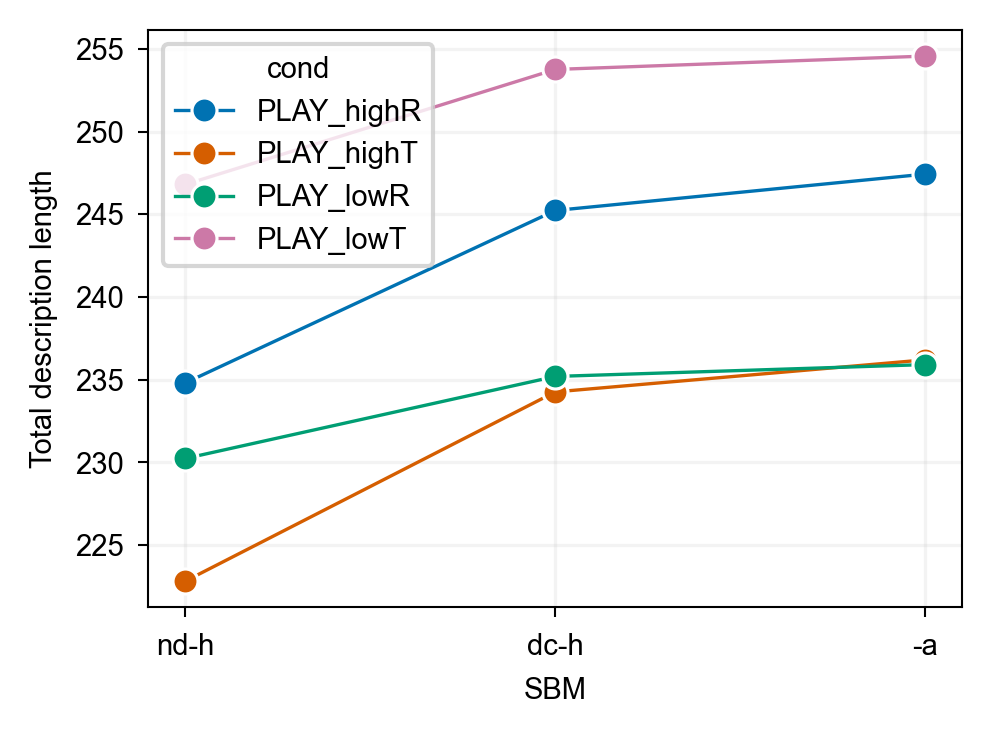

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5))
fs = 7

sns.lineplot(
    data=long_df,
    x='SBM', y='DL', hue='cond',
    units='cond', estimator=None,
    marker='o', lw=0.8, alpha=1.0,
    palette=CUD_COLORS, #['grey'] * pdf.shape[0],
    ax=ax,
    legend=True,
)
ax.set_ylabel("Total description length", fontsize=fs)
ax.tick_params(axis='x', labelrotation=0, labelsize=fs)
ax.tick_params(axis='y', labelsize=fs)
ax.grid(axis='both', linestyle='-', alpha=0.15)

In [21]:
with open(f'{ESTIM_path}/group/desc-evidence.pkl', 'wb') as f:
    pickle.dump(pdf, f)

# with open(f'{ESTIM_path}/group/desc-comparisons.pkl', 'wb') as f:
#     pickle.dump(comp_df, f)

fig.savefig(f'{ESTIM_path}/group/desc-plot.svg', format='svg', bbox_inches='tight', transparent=True)